In [5]:
import os
import yaml
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
import datetime
%matplotlib inline

In [6]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [7]:
alldirs = {}
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir,'survey')
fiberassigndir =  os.path.join(basedir, 'fiberassign')
alldirs['surveydir'] = surveydir
alldirs['fiberassigndir'] = fiberassigndir

brighttargetdir = os.path.join(basedir,'targets/no_spectra/bright')
darktargetdir = os.path.join(basedir,'targets/no_spectra/dark')
alldirs['brighttargetdir'] = brighttargetdir
alldirs['darktargetdir'] = darktargetdir

zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
alldirs['zcatbrightdir'] = zcatbrightdir
alldirs['zcatdarkdir'] = zcatdarkdir

alltargetdir = os.path.join(basedir,'targets/no_spectra/bright')
zcatalldir = os.path.join(basedir,'zcat/all')
alldirs['alltargetdir'] = alltargetdir
alldirs['zcatalldir'] = zcatalldir

In [8]:
for k in alldirs.keys():
    print('Creating {}: {}'.format(k, alldirs[k]))
    os.makedirs(alldirs[k], exist_ok=True)

Creating darktargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/dark
Creating brighttargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
Creating zcatalldir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/all
Creating alltargetdir: /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/bright
Creating fiberassigndir: /global/cscratch1/sd/forero/quicksurvey_example/fiberassign
Creating zcatdarkdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark
Creating zcatbrightdir: /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright
Creating surveydir: /global/cscratch1/sd/forero/quicksurvey_example/survey


# Survey Plan

We create a list of tiles to be observed by running `surveyplan` and `surveysim` for the **first year** of the survey.
The configuration file we used is

In [24]:
cmd  = 'cat  {}/config.yaml'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

####################################################################
# Configuration data for DESI survey planning and scheduling.
####################################################################

#-------------------------------------------------------------------
# Location of the Mayall at KPNO
#-------------------------------------------------------------------

location:
    latitude: 31.963972222 deg
    longitude: -111.599336111 deg
    elevation: 2120 m
    pressure: 78318 Pa    # from 1976 standard atmosphere model
    temperature: 5 C      # a guess at mean night-time temperature
    timezone: US/Arizona

#-------------------------------------------------------------------
# Observing calendar.
#-------------------------------------------------------------------

# Survey nominally starts on night of this date. Format is YYYY-MM-DD.
first_day: 2019-12-01

# Survey nominally ends on morning of this date. Format is YYYY-MM-DD.
last_day: 2020-11-30

# First night of monsoon 

And the detailed script is

In [25]:
cmd  = 'cat  {}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
! $cmd

#!/bin/bash
#############################################################################
# Simulate the baseline survey strategy described in DESI-doc-1767-v3.
# Note that this is one random realization of the observing conditions.
# Change the random seed for a different realization.
# This will take ~1 hours to run and writes ~50MB to $DESISURVEY_OUTPUT.
#############################################################################
export DESISURVEY_OUTPUT=${SCRATCH}'/quicksurvey_example/survey'

INIT_ARGS='--verbose --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
PLAN_ARGS='--verbose --fa-delay 1m --config-file '${DESISURVEY_OUTPUT}/'config.yaml'
SIM_ARGS='--verbose --seed 123 --strategy HA+fallback --config-file '${DESISURVEY_OUTPUT}/'config.yaml'

surveyinit ${INIT_ARGS}
surveyplan --create ${PLAN_ARGS}
surveysim ${SIM_ARGS}

while :
do
    (surveyplan ${PLAN_ARGS}) || break
    (surveysim --resume ${SIM_ARGS}) || break
done


This takes almost four hours to run. 
If you don't want to run it, you can skip to **Run Select Mock Targets**

In [26]:
cmd  = '{}/surveysim_baseline.sh'.format(os.environ['DESISURVEY_OUTPUT'])
print(cmd)
# !$cmd

/global/cscratch1/sd/forero/quicksurvey_example/survey/surveysim_baseline.sh


# Compute exposures files from `progress` data

`progress.fits` is the file that summarizes the survey simulation.
We read that file and write to disk a file with all the `exposures`
made during the survey and two more files with the exposures for dark and bright
surveys. **NOTE**: We include grey exposures into `all_exposures_dark` file.
Bright twilight tiles should be excluded because we don't have a right sky model, but we are including them here anyway.

INFO:progress.py:145:__init__: Loaded progress from /global/cscratch1/sd/forero/quicksurvey_example/survey/progress.fits.


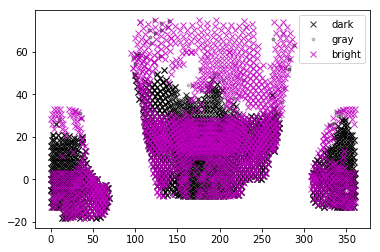

In [27]:
from desisurvey.progress import Progress

if os.path.isfile(os.path.join(alldirs['surveydir'], 'progress.fits')):
    Progress(restore='progress.fits').get_exposures().write(os.path.join(alldirs['surveydir'],'exposures.fits'), overwrite=True)
    
    explist = Table.read(os.path.join(alldirs['surveydir'],'exposures.fits'))

    # separate the exposures for dark and bright programs
    isbright = explist['pass'] > 4 
    isgray = explist['pass'] == 4
    isdark = explist['pass'] < 4
    
    exposurefile_bright = os.path.join(alldirs['surveydir'],'all_exposures_bright.fits')
    Table(explist[isbright]).write(exposurefile_bright, overwrite=True)

    exposurefile_dark = os.path.join(alldirs['surveydir'],'all_exposures_dark.fits')
    Table(explist[~isbright]).write(exposurefile_dark, overwrite=True)
    
    # Make a simple plot
    plt.plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
    plt.plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
    plt.plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
    plt.legend(loc='upper right')

# Select a subset of tiles

We pick 20 tiles nearest RA=180, dec=18. That are already included in the survey simulation outputs.
`fiberassign` will run on those tiles.

In [29]:
tiles = desimodel.io.load_tiles()
explist = Table.read(os.path.join(alldirs['surveydir'],'exposures.fits'))

In [32]:
ntiles = 20

xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(180, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]

#nside = 64
#pixels = desimodel.footprint.tiles2pix(nside, xtiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']))
print('{} tiles covered by {} exposures'.format(len(xtiles), nexp))

20 tiles covered by 33 exposures


In [ ]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)
print(pixels, len(pixels))

# The exposure list could have a repeated tileid. That would mean that 
# the tile had to be targetted more than once.
explist[iobs]

In [ ]:
# save the reduce list of exposures for bright and dark/gray survey
mini_explist = explist[iobs]
isbright = mini_explist['pass'] > 4

exposurefile = os.path.join(surveydir,'exposures_bright.fits')
Table(mini_explist[isbright]).write(exposurefile, overwrite=True)


exposurefile = os.path.join(surveydir,'exposures_dark.fits')
Table(mini_explist[~isbright]).write(exposurefile, overwrite=True)


exposurefile = os.path.join(surveydir,'exposures_all.fits')
Table(mini_explist).write(exposurefile, overwrite=True)

In [ ]:
Table(mini_explist[isbright])

In [ ]:
Table(mini_explist[~isbright])

Plot the tiles and pixels

In [ ]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plt.plot(ra, dec, '-', color='0.6')

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plt.plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plt.plot(xtiles['RA'], xtiles['DEC'], 'rx')
plt.xlim(0,360); plt.ylim(-20, 80)

plt.subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='black', GRAY='blue', BRIGHT='magenta')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plt.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

plt.xlim(170, 190); plt.ylim(13, 23)

In [ ]:
#- Write subset of tiles table to file for input to select_mock_targets --no-spectra
tilefile = os.path.join(darktargetdir,'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
tilefile = os.path.join(brighttargetdir,'test-tiles.fits')
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

# Run serial select_mock_targets --no-spectra

In [ ]:
select_mock_targets_cmd  = "select_mock_targets --no-spectra -c {yamlconfigfile} --nside {healpixnside} --output_dir {outputdir} --seed {seed} --tiles {tilefile}"

cmd = select_mock_targets_cmd.format(yamlconfigfile=os.path.join(darktargetdir,'select-mock-targets-dark.yaml'),
                                    healpixnside=16,
                                    outputdir=darktargetdir,
                                    seed=10,
                                    tilefile=os.path.join(darktargetdir,'test-tiles.fits'))
print(cmd)
#!  -c quicksurvey_example/targets/select-mock-targets.yaml --nside 16 --no-spectra --output_dir ./tmpoutsmall --seed 42 --tiles quicksurvey_example/targets/test-tiles.fits 

In [ ]:
!$cmd

In [ ]:
cmd = "join_mock_targets --force --mockdir "+darktargetdir
! $cmd

In [ ]:
# some sanity checks on the results

In [ ]:
targets = fitsio.read(darktargetdir+'/targets.fits')
truth   = fitsio.read(darktargetdir+'/truth.fits')
mtl     = fitsio.read(darktargetdir+'/mtl.fits')
std     = fitsio.read(darktargetdir+'/standards-dark.fits')
sky     = fitsio.read(darktargetdir+'/sky.fits')

In [ ]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], color='blue', alpha=0.1, s=0.001)
plt.plot(std['RA'], std['DEC'], 'm.')

# Run quicksurvey


## Fiberassign dates

From the `surveysim` data we have to find the dates when `fiberassign` is expected to be run

In [ ]:
#get the dates when fiberassign should be run

px = Table.read(os.getenv('DESISURVEY_OUTPUT')+'/progress.fits')
fiberassign_dates = np.sort(list(set(px['available'])))
fiberassign_dates = fiberassign_dates[fiberassign_dates>0]
print(fiberassign_dates)

#load the dark exposures
exposurefile = os.path.join(surveydir,'exposures_dark.fits')
exposures = Table.read(exposurefile)
expdates = []
for n in exposures['night']:
    a = datetime.datetime.strptime(n, "%Y-%m-%d")
    expdates.append(a.date())
expdates = np.array(expdates)
print(expdates, expdates)

#load the first date of the survey
survey_config = os.path.join(os.getenv('DESISURVEY_OUTPUT'),'config.yaml')
with open(survey_config, 'r') as pfile:
    params = yaml.load(pfile)
pfile.close()
first_day = params['first_day']
last_day = params['last_day']

#compute the dates to run fiberassign to be sure that there is at least one exposure there
fiberassign_dates_dark = []
one_day = datetime.timedelta(days=1)
initial_day = first_day #expdates.min()
for d in fiberassign_dates:
    final_day = first_day + d * one_day
    ii = (expdates > initial_day) & (expdates<=final_day)
    n_in = np.count_nonzero(ii)
    if n_in>0:
        print(initial_day, final_day, n_in)
        fiberassign_dates_dark.append(initial_day.strftime("%Y-%m-%d"))
        initial_day = final_day

print(fiberassign_dates_dark)
fiberdates_filename = os.path.join(fiberassigndir, 'fiberassign_dates_dark.txt')
f = open(fiberdates_filename, 'w')
for d in fiberassign_dates_dark:
    f.write(d+"\n")
f.close()

In [ ]:
! cat /global/cscratch1/sd/forero/quicksurvey_example/fiberassign/fiberassign_dates_dark.txt

In [ ]:
quicksurvey_cmd = "quicksurvey -T {targetdir} -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(targetdir=darktargetdir,
                            exposures=surveydir+'/exposures_dark.fits', 
                            outputdir=zcatdarkdir, 
                            fiberassign_template=fiberassigndir+'/template_fiberassign_dark.txt', 
                            fiberassign_dates=fiberassigndir+'/fiberassign_dates_dark.txt')
print(cmd)

In [ ]:
! $cmd

The list above is the day count after survey start

In [ ]:
zcat     = fitsio.read(zcatdarkdir+'/3/zcat.fits')
zcat_in_mtl = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.figure(figsize=(10,8))
plt.scatter(mtl['RA'], mtl['DEC'], c='b', alpha=0.1, s=0.01)
plt.scatter(mtl[zcat_in_mtl]['RA'], mtl[zcat_in_mtl]['DEC'], c='r', alpha=0.4, s=0.05)
print(np.count_nonzero(zcat_in_mtl))